# Popular Data Science Questions

The primary goal of this project is to answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

To see what kind of content is more popular, we go and ivestigate Stack Overflow a little and found out that it is part of a question and answer website network called Stack Exchange. Stack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and **data science!**


Out of the few Stack Exchange websites there are relevant to our goal, Data Science Stack Exchange (DSSE) is on the bottom 10 sites with respect to the metric - percentage of questions that received answers.

The fact that DSSE is a data science dedicated site (contrarily to the others), coupled with it having a lot of an unanswered questions, makes it an **ideal candidate** for this investigation. DSSE will be the focus of this projectfrom hereon. 


## Gathering Data

Now comes the challenge of accessing the data en masse required for our project. To our luck, Stack Exchange provides a public data base for each of its websites. Here's a [link](https://data.stackexchange.com/datascience/query/new) to query and explore Data Science Stack Exchange's database.


After exploring the Data Science Stack Exchange's data model and investigating a few of the tables, the foolowing  tables sound more promising for our analysis:

- Posts
- PostType
- Tags
- TagSynonyms

### Investigating relevant tables

The posts table has a lot of columns. The last few columns 'Score', 'ViewCount', 'AnswerCount', 'FavoriteCount' contain information about how popular the post is — the kind of information we're after.

And also by querying the PostTypes table, we see that there are eight different types of post. 

###### PostTypes

Id | Name
------------ | -------------
1 | Question
2 | Answer
3 | Wiki
4 | TagWikiExcerpt
5 | TagWiki
6 | ModeratorNomination
7 | WikiPlaceholder
8 | PrevilegeWiki

Before we try to figure out which of them are relevant to us, let's check how many of them there are.


PostTypeId | NrofPosts
------------ | -------------
1 | 21446
2 | 23673
4 | 236
5 | 236
6 | 11
7 | 1

Due to their low volume, anything that isn't questions or answers is mostly inconsequential.  Even if it happens to be the case that such kind of posts is immensely popular, they would just be outliers and not relevant to us. For the purpose of this project, We'll then just focus on the questions. 

And also, since we're only interested in recent posts, we'll limit our analysis to the posts of 2019. 

We run a query against the SEDE DSSE database that extracts the relevant columns for all the questions in 2019. The result of the query is stored in a file called 2019_questions.csv.

## Read in the data

In [1]:
import pandas as pd
from csv import reader

In [2]:
questions_2019 = pd.read_csv("2019_questions.csv")
questions_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


### Dealing with missing values

We notice that all the columns eccept the 'FavoriteCount' column has no null values. 

The 'FavoriteCount' column seems to be having a signiifcant number of null values.

FavoriteCount indicates How many times the question was favored (only applicable to question posts). This means that we can fill the null values in the column with '0'

In [3]:
questions_2019 = questions_2019.fillna(0)
questions_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


### Setting the appropriate  datatypes for the columns

In [4]:
questions_2019['FavoriteCount'] = questions_2019['FavoriteCount'].astype(int)
questions_2019['CreationDate'] = pd.to_datetime(questions_2019['CreationDate'])
questions_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


### Cleaning Tags Column

The values in the Tags column are strings that look like this:

"<machine-learning><regression><linear-regression><regularization>"

We'll want to transform this string in something more suitable to use typical string methods. Our goal will be to transform strings like the above in something like:

"machine-learning,regression,linear
regression,regularization"

We can then split on , to obtain a list.

In [5]:
questions_2019["Tags"] = questions_2019["Tags"].str.replace('><',',')
questions_2019["Tags"] = questions_2019["Tags"].str.replace('<','')
questions_2019["Tags"] = questions_2019["Tags"].str.replace('>','')
questions_2019["Tags"] = questions_2019["Tags"].str.split(',')
questions_2019['Tags'].head()

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object

### Finding popular tags

We determine the most popular tafs by considering two different popularity proxies: 

- for each tag we'll count how many times the tag was used
- how many times a questions that tag was viewed. 

In [6]:
tags_count = {}
for row in questions_2019['Tags']:
    for tag in row:
        if tag in tags_count:
            tags_count[tag] += 1
        else:
            tags_count[tag] = 1

sorted_list = sorted(tags_count.items(), key=lambda x: x[1], reverse=True)
top_tags_count = dict(sorted_list[0:25])

most_used = pd.DataFrame.from_dict(top_tags_count, orient = 'index')
#most_used = most_used.reset_index()
#most_used = most_used.rename(columns = {'index' : 'Tag',0:'Count'})
most_used = most_used.rename(columns = {0:'Count'})
most_used = most_used.sort_values(by = ['Count'], ascending = False)
most_used

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


In [7]:
#counting the number of views that each tag has got
views_count = {}
                
for i in range(len(questions_2019)) : 
    for tag in questions_2019.loc[i,'Tags']:
        if tag in views_count:
            views_count[tag] += questions_2019.loc[i,'ViewCount']
        else:
             views_count[tag] = questions_2019.loc[i,'ViewCount']

sorted_list = sorted(views_count.items(), key=lambda x: x[1], reverse=True)
top_views_count = dict(sorted_list[0:25])

most_viewed = pd.DataFrame.from_dict(top_views_count, orient = 'index')
#most_viewed = most_viewed.reset_index()
#most_viewed = most_viewed.rename(columns = {'index' : 'Tag', 0:'No_of_Views'})
most_viewed = most_viewed.rename(columns = {0:'No_of_Views'})
most_viewed = most_viewed.sort_values(by = ['No_of_Views'], ascending = False)
most_viewed


,No_of_Views
python,537585
machine-learning,388499
keras,268608
deep-learning,233628
pandas,201787
neural-network,185367
scikit-learn,128110
tensorflow,121369
classification,104457
dataframe,89352


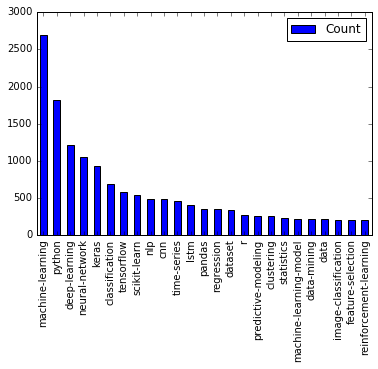

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

most_used.plot(kind = "bar")
plt.xticks(rotation = 90)
plt.show()

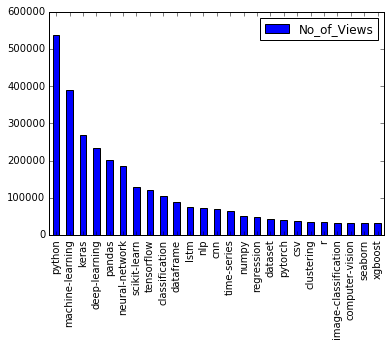

In [9]:
most_viewed.plot(kind = "bar")
plt.xticks(rotation = 90)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d6ed01358>],
      dtype=object)

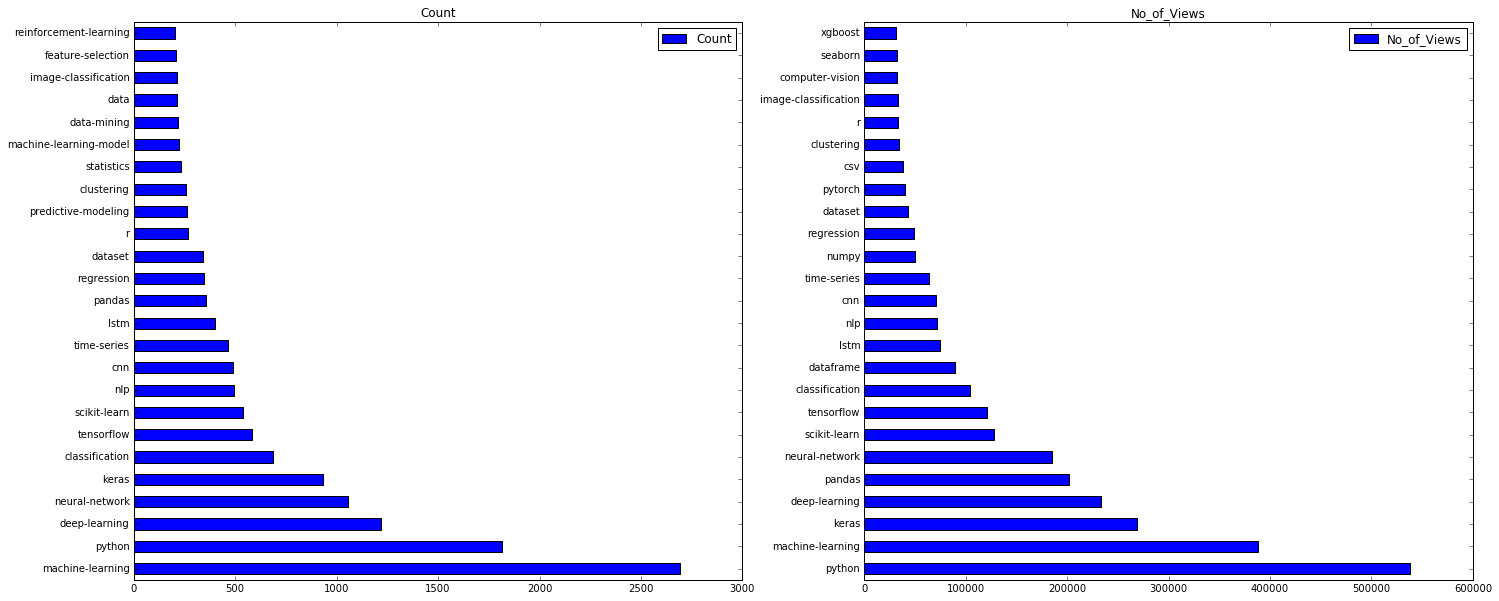

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

most_used is a dataframe that counts how many times each of the top 25 tags was used.
most_viewed is a dataframe that counts how many times each of the top 25 tags was viewed.

Looking at the results, we see that most top tags are present in both dataframes. 

Let's see what tags are in most_used, but not in most_viewed.

In [11]:
in_used = pd.merge(most_used, most_viewed, how="left", 
                   left_index=True, right_index=True)
in_used

,Count,No_of_Views
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0
cnn,489,70349.0


Let's see what tags are in most_viewed, but not in most_used.

In [12]:
in_viewed = pd.merge(most_used, most_viewed, how="right", 
                     left_index=True, right_index=True)
in_viewed

,Count,No_of_Views
python,1814.0,537585
machine-learning,2693.0,388499
keras,935.0,268608
deep-learning,1220.0,233628
pandas,354.0,201787
neural-network,1055.0,185367
scikit-learn,540.0,128110
tensorflow,584.0,121369
classification,685.0,104457
dataframe,NaN,89352


## Finding relationships b/w tags

Some tags also stand out as being related. For example, python is related to pandas, because pandas is a Python library.

We will look for some ways to find relationships between pair of tags and between multiple tags.

One way of trying to measure how pairs of tags are related to each other, is to count how many times each pair appears together. 

We'll begin by creating a list of all tags. We'll then create a dataframe where each row will represent a tag, and each column as well.

In [13]:
all_tags = list(tags_count.keys())

In [14]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:5,0:5]

,text-filter,anaconda,machine-translation,software-development,kitti-dataset
text-filter,NaN,NaN,NaN,NaN,NaN
anaconda,NaN,NaN,NaN,NaN,NaN
machine-translation,NaN,NaN,NaN,NaN,NaN
software-development,NaN,NaN,NaN,NaN,NaN
kitti-dataset,NaN,NaN,NaN,NaN,NaN


We will now fill this dataframe with zeroes and then, for each lists of tags in questions["Tags"], we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used together.

In [15]:
associations.fillna(0, inplace=True)

for tags in questions_2019["Tags"]:
    associations.loc[tags, tags] += 1

As this dataframe is quite large. Let's focus our attention on the most used tags. 

In [16]:
relations_most_used = associations.loc[most_used.index, most_used.index]
relations_most_used

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,r,predictive-modeling,clustering,statistics,machine-learning-model,data-mining,data,image-classification,feature-selection,reinforcement-learning
machine-learning,2693,499,429,366,195,259,106,188,113,124,...,63,123,61,89,139,95,54,68,88,50
python,499,1814,160,137,280,98,167,235,71,62,...,24,35,45,35,37,27,35,24,26,17
deep-learning,429,160,1220,305,247,59,136,16,72,160,...,5,32,2,12,19,24,2,66,21,54
neural-network,366,137,305,1055,235,65,108,24,24,118,...,9,13,8,11,10,4,4,49,9,25
keras,195,280,247,235,935,58,256,34,23,116,...,10,11,0,3,17,1,1,46,3,8
classification,259,98,59,65,58,685,20,47,35,20,...,10,27,12,19,21,19,9,16,21,0
tensorflow,106,167,136,108,256,20,584,15,11,57,...,1,6,0,0,9,0,0,15,0,10
scikit-learn,188,235,16,24,34,47,15,540,12,0,...,1,12,24,6,18,2,4,1,23,0
nlp,113,71,72,24,23,35,11,12,493,7,...,4,1,9,3,4,8,5,0,5,4
cnn,124,62,160,118,116,20,57,0,7,489,...,2,6,0,1,4,2,1,67,1,2


We extracted the associations between most_used tags into relations_most_used dataframe. The values on the diagonal tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.

It's hard to understand what is going on even in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values on the diagonal, otherwise the colors will be too skewed.

In [17]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

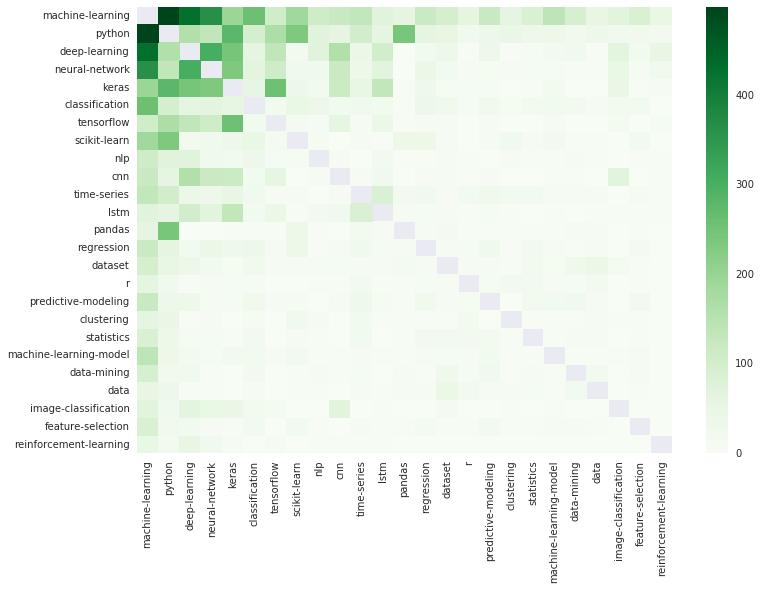

In [18]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the upper left corner. 

Keras, scikit-learn, TensorFlow are all Python libraries that allow programmers to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. 

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

## Is Deep learning just a fad?

Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? 

We run a query on SEDE database that fetches all of the questions ever asked on DSSE, their dates and tags and store the result in all_questions.csv

In the following steps, we will track the interest in deep learning across time. We will, more specifically:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

In [19]:
all_questions = pd.read_csv("all_questions.csv")
all_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null object
Tags            21576 non-null object
dtypes: int64(1), object(2)
memory usage: 505.8+ KB


In [20]:
all_questions["Tags"] = all_questions["Tags"].str.replace('><',',')
all_questions["Tags"] = all_questions["Tags"].str.replace('<','')
all_questions["Tags"] = all_questions["Tags"].str.replace('>','')
all_questions["Tags"] = all_questions["Tags"].str.split(',')
all_questions['Tags'].head()

0        [python, keras, tensorflow, cnn, probability]
1                                     [neural-network]
2                        [python, ibm-watson, chatbot]
3                                              [keras]
4    [r, predictive-modeling, machine-learning-mode...
Name: Tags, dtype: object

In [21]:
all_questions['CreationDate'] = pd.to_datetime(all_questions['CreationDate'])
all_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null datetime64[ns]
Tags            21576 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

After looking on Google and the most_used tags, we arrive at a list of tags. 

The definition of what constitutes a deep learning tag is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].



In [22]:
#function that classifies question as a deep learning related question
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

In [23]:
all_questions["DeepLearning"] = all_questions["Tags"].apply(class_deep_learning)
all_questions.head()

,Id,CreationDate,Tags,DeepLearning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


Data science as a field doesn't show much changes daily, weekly or monthly. Therefore, we can safely go for quarterly time period interval to analyze how deep learning questions evolved through time.  

In [25]:
print(all_questions['CreationDate'].max())
print(all_questions['CreationDate'].min())

2020-01-19 03:01:03
2014-05-13 23:58:30


In [27]:
import datetime as dt
all_questions['Year'] = all_questions['CreationDate'].dt.year
all_questions['Year'].value_counts()

2019    8810
2018    5475
2017    2957
2016    2146
2015    1167
2014     562
2020     459
Name: Year, dtype: int64

And since we don't have data for the whole quarter of 2020, we drop the data in our analysis.

In [28]:
all_questions = all_questions[all_questions['Year'] < 2020]
all_questions['Year'].value_counts()

2019    8810
2018    5475
2017    2957
2016    2146
2015    1167
2014     562
Name: Year, dtype: int64

In [29]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_questions["Quarter"] = all_questions["CreationDate"].apply(fetch_quarter)
all_questions.head()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Id,CreationDate,Tags,DeepLearning,Year,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,2019,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,2019,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,2019,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,2019,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,2019,19Q1


We'll group by quarter and:

- Count the number of deep learning questions.
- Count the total number of questions.
- Compute the ratio between the two numbers above.

In [31]:
quarterly = all_questions.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]

quarterly.reset_index(inplace=True)
quarterly.head(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222
3,15Q1,18,190,0.094737
4,15Q2,28,284,0.098592


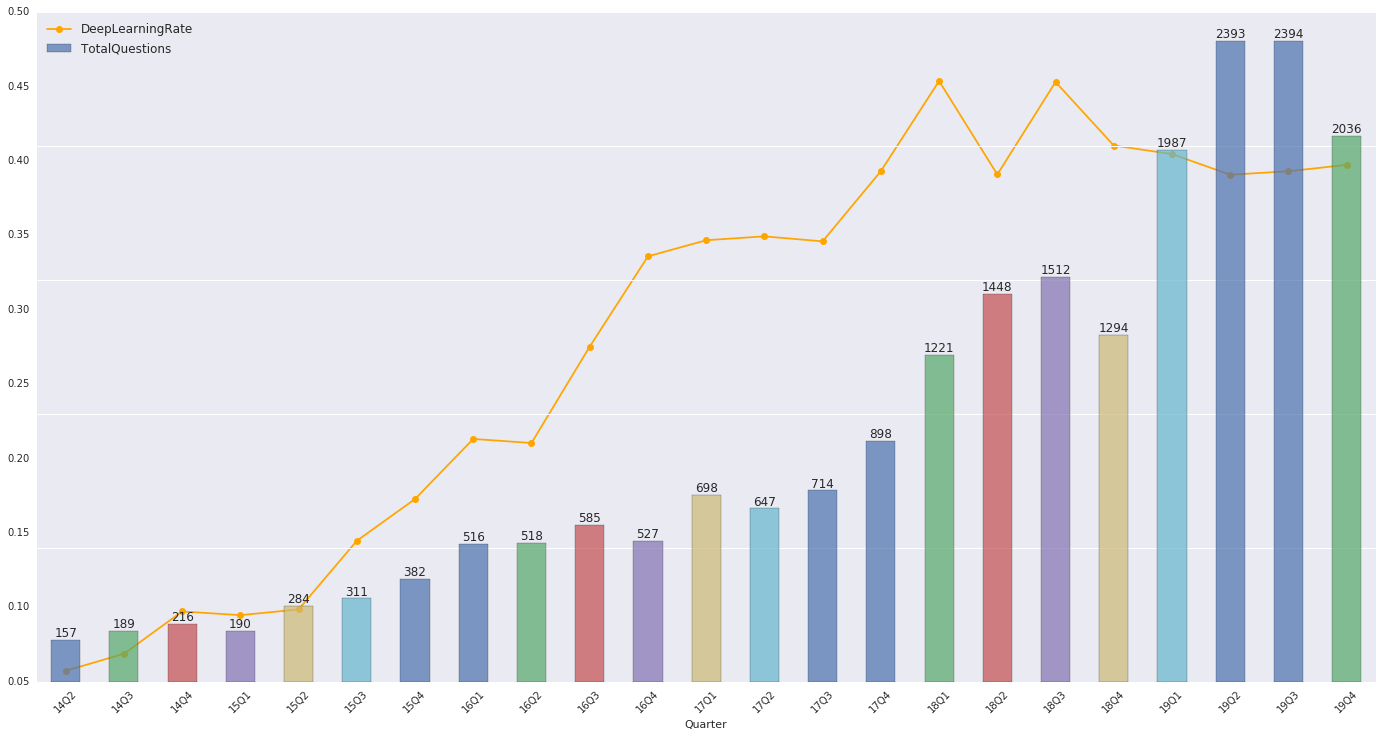

In [32]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it is plateauing recently. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.